In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

from lsst.sims.utils import hpid2RaDec
import pandas as pd

In [2]:
# Connect to a database. Available here: http://astro-lsst-01.astro.washington.edu:8080/
dbFile = 'baseline_nexp2_v1.6_10yrs.db'
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)


In [3]:
bundleList = []
nside = 128
# Note I'm putting a depth cut on here so we don't count any very shallow images (e.g., taken in twilight)
sql = 'filter="g" and fiveSigmaDepth > 24.3 and seeingFwhmEff < 1.0'
metric = metrics.MinMetric(col='observationStartMJD')
slicer = slicers.HealpixSlicer(nside=nside)
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))

# Let's just get a count of all observations while we're at it
sql='filter="g"'
metric=metrics.CountMetric(col='night', units='N')
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


Querying database SummaryAllProps with constraint filter="g" for columns ['fieldRA', 'fieldDec', 'night']
Found 206839 visits
Running:  ['opsim_Count_night_g_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="g" and fiveSigmaDepth > 24.3 and seeingFwhmEff < 1.0 for columns ['fieldRA', 'observationStartMJD', 'fieldDec']
Found 81268 visits
Running:  ['opsim_Min_observationStartMJD_g_and_fiveSigmaDepth_gt_24_3_and_seeingFwhmEff_lt_1_0_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="g"" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 1538 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 66.5065  dipole: lon: 70.3948, lat: -70.033, amp: 19.3653
  mono, lon, lat, amp


Plotting complete.
Plotting figures with "filter="g" and fiveSigmaDepth > 24.3 and seeingFwhmEff < 1.0" constraint now.


/Users/yoachim/git_repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 583 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))
/Users/yoachim/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 60095.8  dipole: lon: -99.8678, lat: 29.3105, amp: 173.946
  mono, lon, lat, amp


Plotting complete.


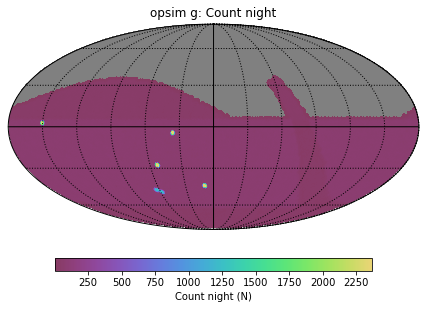

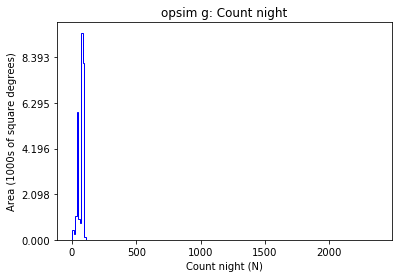

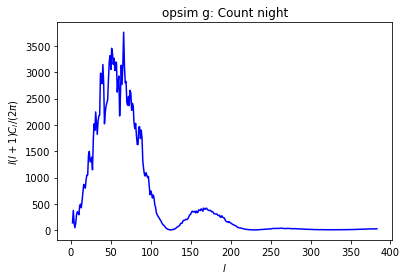

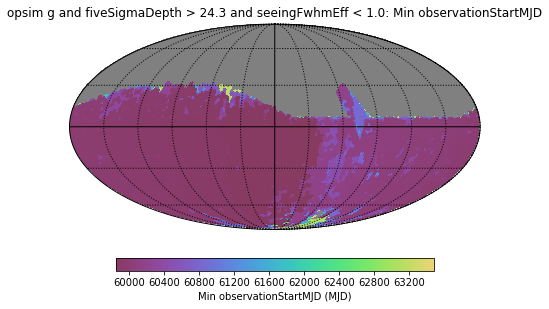

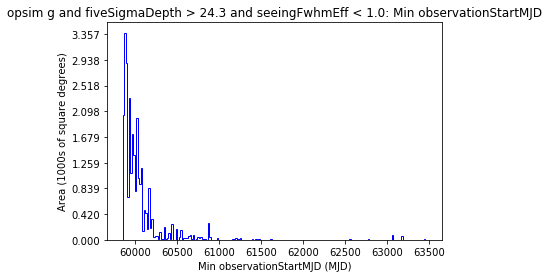

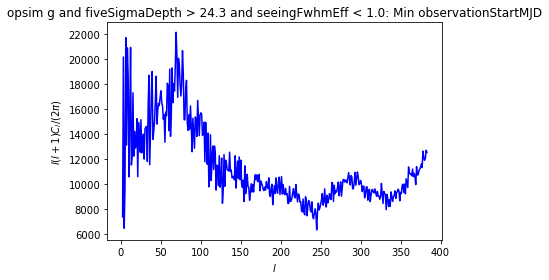

In [4]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [5]:
# Only include parts of the footprint that get observed a lot (cuts out pixels that were observed becuase of dithers)
good_vals = np.where((bundleList[1].metricValues > 50) & (bundleList[0].metricValues.mask == False))[0]
good_vals.size, np.unique(bundleList[0].metricValues[good_vals]).size

(91327, 4237)

In [6]:

df = pd.DataFrame()

In [7]:
df['mjd_min'] = bundleList[0].metricValues[good_vals]
ra, dec = hpid2RaDec(nside, good_vals)
df['RA'] = ra
df['dec'] = dec
df['hpid'] = good_vals
df.to_csv('start_times.dat')